# 인공지능 Project
[붓꽃 분류 모델 개발 프로젝트]

2014312026/메카트로닉스/이재은

프로젝트를 진행하기 전에, 데이터 전처리 및 모델링에 쓰일 라이브러리를 임포트 하자.

In [550]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 사이킷런의 붓꽃 데이터를 불러올 수 있음
from sklearn.datasets import load_iris

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

In [551]:
# 붓꽃 데이터 세트를 로딩한다.
iris = load_iris()

# iris.data는 Iris 데이터 세트에서 피처(feature)만으로 된 데이터를 numpy로 가지고 있다. 
iris_data = iris.data

# iris.target은 붓꽃 데이터 세트에서 레이블(결정 값) 데이터를 numpy로 가지고 있다.
iris_label = iris.target

# 붓꽃 데이터 세트를 자세히 보기 위해 DataFrame으로 변환한다. 
iris_df = pd.DataFrame(data =  iris_data, columns = iris.feature_names)
iris_df['label'] = iris.target
iris_df.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


독립 변수(피처)는 sepal length, sepal width, petal length, petal width로 구성되어 있고, 어떤 품종(setosa,versicolor,virginica)인지 맞춰야하는 label이 있다. 

우선, 각 피처(독립변수)들의 관계로 품종(종속변수)를 어떤 식으로 표현하고 있는지 시각화를 해보는 것이 좋을 것 같다.

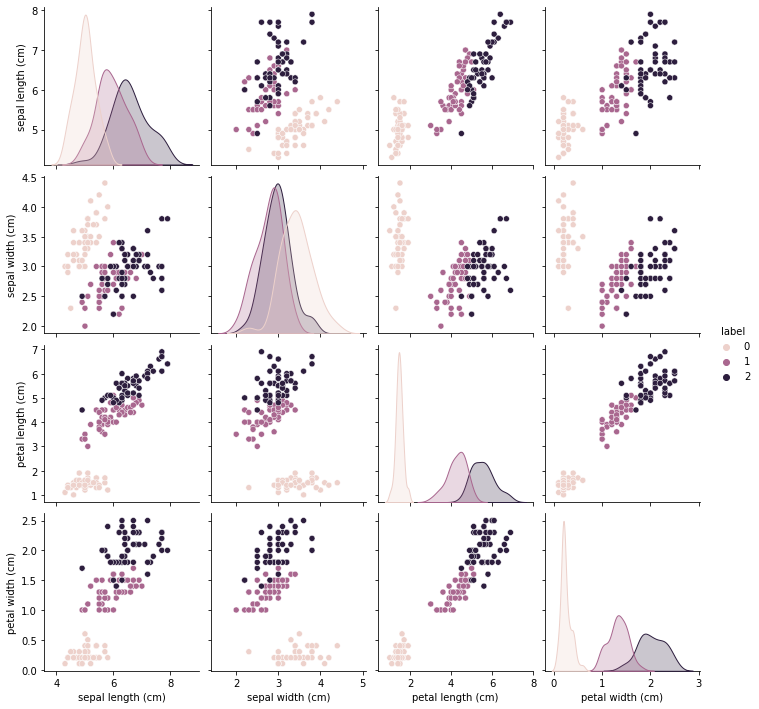

In [552]:
sns.pairplot(iris_df,hue='label')

각 독립변수들의 관계로 품종의 분포와 산점도(scatter plot)을 확인해 본 결과, 존재하는 독립 변수들로 어느정도 명확하게 붓꽃의 품종의 분류를 할 수 있는 것으로 판단된다. 이를 통해 두가지의 방법을 비교해 보면 좋을 것 같다.

1. 간단한 전처리 후 분류 모델링
2. 자체적으로 품종을 분류할 수 있는 클러스터링(군집 분석) 변수를 만든 후, 분류 모델링

## 1. 간단한 전처리 후 분류 모델링

In [553]:
iris_df.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
label                0
dtype: int64

결측치는 없는 것으로 판단된다.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

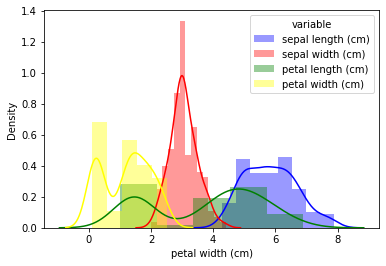

In [554]:
sns.distplot(iris_df["sepal length (cm)"], 
             color="blue", label="sepal length (cm)")
sns.distplot(iris_df["sepal width (cm)"],
             color="red",label = 'sepal width (cm)')
sns.distplot(iris_df["petal length (cm)"], 
             color="green", label="petal length (cm)")
sns.distplot(iris_df["petal width (cm)"], 
             color="yellow", label="petal width (cm)")
plt.legend(title="variable")
plt.show()

In [555]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


각 변수별로 범위가 크기 때문에 데이터를 정제해줄 필요가 있다. 머신러닝 모델의 Tree 기반 모델은 이러한 전처리 작업이 필요가 없는 장점이 있지만, 아직까지 딥러닝 모델은 이 작업을 해줘야한다.(가중치 문제 때문임)

In [556]:
scaler = StandardScaler()
new_df=pd.DataFrame(scaler.fit_transform(iris_df.drop('label',axis=1)),
                    columns = iris_df.columns[:-1])
new_df['label'] = iris_df['label']
new_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,-0.900681,1.019004,-1.340227,-1.315444,0
1,-1.143017,-0.131979,-1.340227,-1.315444,0
2,-1.385353,0.328414,-1.397064,-1.315444,0
3,-1.506521,0.098217,-1.283389,-1.315444,0
4,-1.021849,1.249201,-1.340227,-1.315444,0


정규화가 잘된 것을 확인할 수 있다.

In [557]:
new_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,-0.900681,1.019004,-1.340227,-1.315444,0
1,-1.143017,-0.131979,-1.340227,-1.315444,0
2,-1.385353,0.328414,-1.397064,-1.315444,0
3,-1.506521,0.098217,-1.283389,-1.315444,0
4,-1.021849,1.249201,-1.340227,-1.315444,0


## 2. 군집화 변수 생성
- 군집화 변수를 생성하는 이유는 간단하다. 모델이 좀 더, 데이터를 이해하기 쉽게 만들어 주는 것이다. 1000명의 사람을 단순히 키와 몸무게로 성별을 분류 하는 것 보다는, 그 관계속에서 새로운 범주를 찾아 주면 좀 더 쉽게 이해할 수 있지 않을까?

우선 군집화를 진행할 때는, 변수별 scale이 비슷해야하기 때문에 위에서 만든 new_df를 그대로 사용하여 파생변수를 만들도록 하자.

### DBSCAN 클러스터링 알고리즘 적용
- K means 클러스터링은 반경을 기준으로 군집화를 진행하기 때문에, 상대적으로 중심부와 거리가 있는 데이터를 오분류할 가능성이 크다. 그렇기 때문에 밀도 기반 클러스터링의 DBSCAN을 적용했다.

In [558]:
clustering = DBSCAN(eps=0.5,min_samples=2).fit(new_df.drop('label',axis=1))

In [559]:
new_df['clustering'] = clustering.labels_

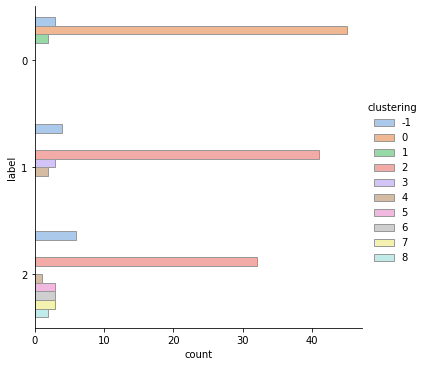

In [560]:
sns.catplot(y="label", hue="clustering", kind="count",
            palette="pastel", edgecolor=".6",
            data=new_df)

클러스터링은 정답이 없기 때문에 방향에 맞게 끔 최대한 파라미터를 조절하는 방법밖에는 없다. 지금처럼 데이터가 적은 상태에서 군집 개수를 많이 생성하는 것은 썩 좋은 방법은 아니지만, 데이터가 많이 보유가 되면 군집 개수는 늘리는 것이 바람직하다.

## 예측 모델링 진행
이제 클러스터링을 사용한 데이터와 그렇지 않은 데이터를 모델링에 적용해 비교해 보자.

다중 분류 문제이기 때문에, 모델 결과는 크로스 엔트로피를 적용을 해아한다. 그러므로 종속변수(Y,품종)에 원핫 인코딩을 적용해 주자.

In [561]:
from sklearn.preprocessing import LabelEncoder

X = new_df.drop(['label','clustering'],axis=1)
y = new_df['label']

encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'y_test')]

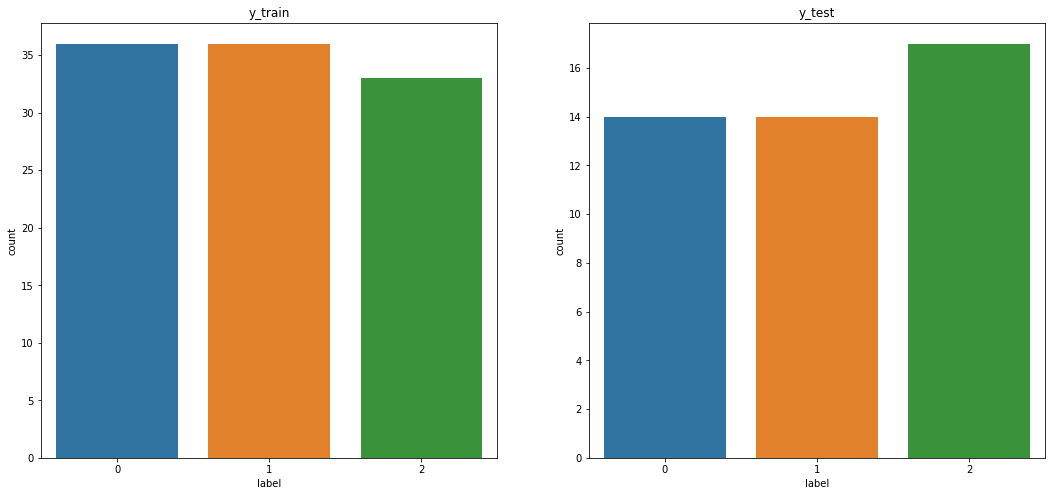

In [562]:
# train데이터와 test데이터의 품종 분포 확인
from sklearn.model_selection import train_test_split
X_train, X_test_ver1, y_train, y_test_ver1 = train_test_split(new_df.drop('label',axis=1),new_df['label'], 
                                                    test_size=0.3,random_state=11) 
X_train.shape, X_test_ver1.shape, y_train.shape, y_test_ver1.shape

figure, ((ax1),(ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18,8)
sns.countplot(y_train,ax=ax1)
sns.countplot(y_test_ver1,ax=ax2)

ax1.set(title="y_train")
ax2.set(title="y_test")

train 데이터와 test데이터의 품종의 분포가 약간 다르긴 하지만, 크게 불균형적이지 않기 떄문에 따로 처리할 것은 없다고 판단함.

In [563]:
# 학습용 데이터와 테스트용 데이터 분리 -> 원한 인코딩 적용
X_train, X_test_ver1, y_train, y_test_ver1 = train_test_split(X, Y, 
                                                    test_size=0.3, 
                                                    random_state=11) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105, 4), (45, 4), (105, 3), (45, 3))

####신경망 모델 1

In [564]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model1 = Sequential()

model1.add(Dense(64,input_shape=(4,),activation='relu'))
model1.add(Dense(32,activation='relu'))
model1.add(Dense(16,activation='relu'))
model1.add(Dense(3,activation='softmax'))

model1.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

model1.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 64)                320       
_________________________________________________________________
dense_245 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_246 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_247 (Dense)            (None, 3)                 51        
Total params: 2,979
Trainable params: 2,979
Non-trainable params: 0
_________________________________________________________________


오버피팅을 방지하기 위해, validation 셋을 설정하고, validation set이 개선이 안되면 조기종료를 할 수 있게 하자.

In [565]:
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
hist1 = model.fit(X_train, y_train,epochs=1000, validation_split=0.3,callbacks=[es])

Epoch 1/1000
3/3 [==============================] - 0s 15ms/step - loss: 3.3229e-04 - accuracy: 1.0000 - val_loss: 0.2454 - val_accuracy: 0.9375
Epoch 2/1000
3/3 [==============================] - 0s 8ms/step - loss: 3.2876e-04 - accuracy: 1.0000 - val_loss: 0.2451 - val_accuracy: 0.9375
Epoch 3/1000
3/3 [==============================] - 0s 6ms/step - loss: 3.2150e-04 - accuracy: 1.0000 - val_loss: 0.2453 - val_accuracy: 0.9375
Epoch 4/1000
3/3 [==============================] - 0s 5ms/step - loss: 3.1834e-04 - accuracy: 1.0000 - val_loss: 0.2453 - val_accuracy: 0.9375
Epoch 5/1000
3/3 [==============================] - 0s 5ms/step - loss: 3.1327e-04 - accuracy: 1.0000 - val_loss: 0.2450 - val_accuracy: 0.9688
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 3.0936e-04 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy: 0.9688
Epoch 7/1000
3/3 [==============================] - 0s 6ms/step - loss: 3.0546e-04 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy

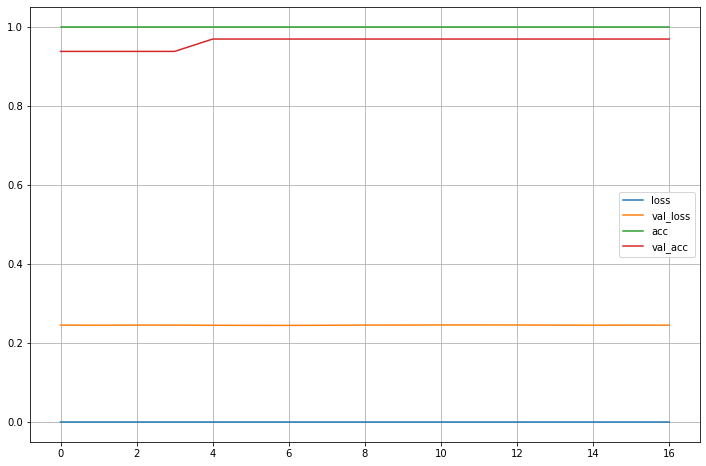

In [566]:
plt.figure(figsize=(12,8))
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.legend(['loss','val_loss', 'acc','val_acc'])
plt.grid()
plt.show()

#### 신경망 모델 2

In [567]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model2 = Sequential()

model2.add(Dense(128,input_shape=(4,),activation='relu'))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(32,activation='relu'))
model2.add(Dense(16,activation='relu'))
model2.add(Dense(3,activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='Adam', 
              metrics=['accuracy'])

model2.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_248 (Dense)            (None, 128)               640       
_________________________________________________________________
dense_249 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_250 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_251 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_252 (Dense)            (None, 3)                 51        
Total params: 11,555
Trainable params: 11,555
Non-trainable params: 0
_________________________________________________________________


In [568]:
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
hist = model2.fit(X_train, y_train,epochs=1000, validation_split=0.3,callbacks=[es])

Epoch 1/1000
3/3 [==============================] - 0s 51ms/step - loss: 1.0657 - accuracy: 0.5479 - val_loss: 1.0298 - val_accuracy: 0.8750
Epoch 2/1000
3/3 [==============================] - 0s 6ms/step - loss: 1.0032 - accuracy: 0.8082 - val_loss: 0.9843 - val_accuracy: 0.8750
Epoch 3/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.9474 - accuracy: 0.8356 - val_loss: 0.9358 - val_accuracy: 0.8750
Epoch 4/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.8907 - accuracy: 0.8356 - val_loss: 0.8790 - val_accuracy: 0.8750
Epoch 5/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.8213 - accuracy: 0.8356 - val_loss: 0.8178 - val_accuracy: 0.8750
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.7470 - accuracy: 0.8493 - val_loss: 0.7523 - val_accuracy: 0.8750
Epoch 7/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.6696 - accuracy: 0.8630 - val_loss: 0.6858 - val_accuracy: 0.8750
Epoch 8/1000
3/3 [=

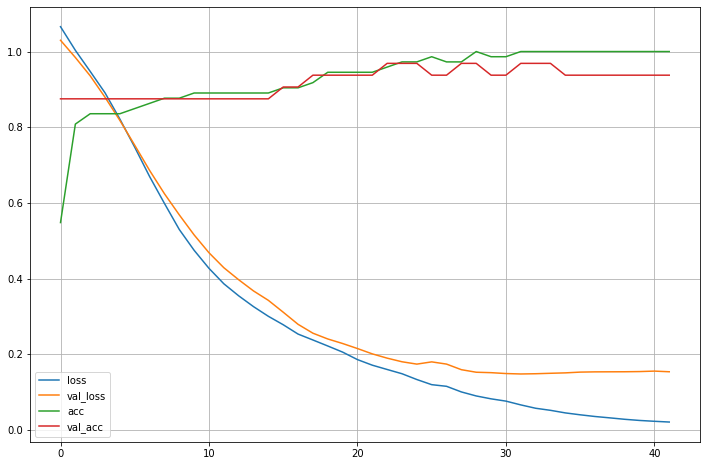

In [569]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss', 'acc','val_acc'])
plt.grid()
plt.show()

신경망 모델2는 모델1보다 하나 더 많은 층과 더 많은 노드수를 설정해서 약간의 모델 성능 개선이 보이는 것 같다. 하지만 Test 셋에 대해서는 어떻게 나올지는 아무도 모르기 떄문에 최종 판단은 주의해야할 것이다. 왜냐하면 지금 데이터 셋도 상당히 적기 때문에..

#### 신경망 모델3 (클러스터링 변수가 있는 데이터로 모델링)
- 모델2를 활용해보자.

In [570]:
#클러스터링 변수 원핫 인코딩
cl = encoder.fit_transform(new_df['clustering'])
cl_df = pd.get_dummies(new_df['clustering']).values
cl_df = pd.DataFrame(cl_hot)

In [571]:
new_df=pd.concat([new_df,cl_df],axis=1)

In [572]:
#클러스터링 변수 원핫 인코딩
cl = encoder.fit_transform(new_df['clustering'])
cl_df = pd.get_dummies(new_df['clustering']).values
cl_df = pd.DataFrame(cl_hot)
new_df=pd.concat([new_df,cl_df],axis=1)

X = new_df.drop(['label'],axis=1)
y = new_df['label']

encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

# 학습용 데이터와 테스트용 데이터 분리 -> 원한 인코딩 적용
X_train, X_test_ver2, y_train, y_test_ver2 = train_test_split(X, Y, 
                                                    test_size=0.3, 
                                                    random_state=11) 
X_train.shape, X_test_ver2.shape, y_train.shape, y_test_ver2.shape

((105, 21), (45, 21), (105, 3), (45, 3))

In [573]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model3 = Sequential()

model3.add(Dense(64,input_shape=(X_train.shape[1],),activation='relu'))
model3.add(Dense(32,activation='relu'))
model3.add(Dense(16,activation='relu'))
model3.add(Dense(3,activation='softmax'))

model3.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

model3.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_253 (Dense)            (None, 64)                1408      
_________________________________________________________________
dense_254 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_255 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_256 (Dense)            (None, 3)                 51        
Total params: 4,067
Trainable params: 4,067
Non-trainable params: 0
_________________________________________________________________


In [574]:
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
hist = model3.fit(X_train, y_train,epochs=1000, validation_split=0.3,callbacks=[es])

Epoch 1/1000
3/3 [==============================] - 0s 55ms/step - loss: 1.1189 - accuracy: 0.3014 - val_loss: 1.1186 - val_accuracy: 0.5938
Epoch 2/1000
3/3 [==============================] - 0s 6ms/step - loss: 1.0251 - accuracy: 0.6164 - val_loss: 1.0401 - val_accuracy: 0.6562
Epoch 3/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.9507 - accuracy: 0.6712 - val_loss: 0.9801 - val_accuracy: 0.6562
Epoch 4/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.8924 - accuracy: 0.6986 - val_loss: 0.9285 - val_accuracy: 0.6562
Epoch 5/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.8390 - accuracy: 0.6986 - val_loss: 0.8856 - val_accuracy: 0.6562
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.7907 - accuracy: 0.6986 - val_loss: 0.8455 - val_accuracy: 0.6562
Epoch 7/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.7415 - accuracy: 0.6986 - val_loss: 0.8084 - val_accuracy: 0.6562
Epoch 8/1000
3/3 [=

### 신경망 모델4

In [575]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model4 = Sequential()

model4.add(Dense(128,input_shape=(X_train.shape[1],),activation='relu'))
model4.add(Dense(64,activation='relu'))
model4.add(Dense(32,activation='relu'))
model4.add(Dense(16,activation='relu'))
model4.add(Dense(3,activation='softmax'))

model4.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

model4.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_257 (Dense)            (None, 128)               2816      
_________________________________________________________________
dense_258 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_259 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_260 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_261 (Dense)            (None, 3)                 51        
Total params: 13,731
Trainable params: 13,731
Non-trainable params: 0
_________________________________________________________________


In [576]:
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
hist = model4.fit(X_train, y_train,epochs=1000, validation_split=0.3,callbacks=[es])

Epoch 1/1000
3/3 [==============================] - 0s 57ms/step - loss: 1.0949 - accuracy: 0.4658 - val_loss: 0.9981 - val_accuracy: 0.6562
Epoch 2/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.0085 - accuracy: 0.5068 - val_loss: 0.9287 - val_accuracy: 0.6875
Epoch 3/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.9456 - accuracy: 0.5753 - val_loss: 0.8605 - val_accuracy: 0.8750
Epoch 4/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.8797 - accuracy: 0.8630 - val_loss: 0.7865 - val_accuracy: 0.8750
Epoch 5/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.8064 - accuracy: 0.8767 - val_loss: 0.7046 - val_accuracy: 0.8750
Epoch 6/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.7382 - accuracy: 0.9041 - val_loss: 0.6241 - val_accuracy: 0.9375
Epoch 7/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.6741 - accuracy: 0.9041 - val_loss: 0.5465 - val_accuracy: 0.9375
Epoch 8/1000
3/3 [=

# 최종 성능 비교

In [577]:
from sklearn.metrics import accuracy_score

In [578]:
model1_pre=model1.predict_classes(X_test_ver1)

In [579]:
coll_list=[]
for idx in range(y_test_ver1.shape[0]):
  num=0
  for ii in range(y_test_ver1.shape[1]):
    if y_test[idx][ii] != 1:
      num +=1
    else:
      coll_list.append(num)

In [580]:
accuracy_score(coll_list,model1_pre)

0.3111111111111111

In [581]:
model2_pre=model2.predict_classes(X_test_ver1)

In [582]:
accuracy_score(coll_list,model2_pre)

0.8666666666666667

In [583]:
coll_list=[]
for idx in range(y_test_ver2.shape[0]):
  num=0
  for ii in range(y_test_ver2.shape[1]):
    if y_test[idx][ii] != 1:
      num +=1
    else:
      coll_list.append(num)

In [584]:
model3_pre=model3.predict_classes(X_test_ver2)

In [585]:
accuracy_score(coll_list,model3_pre)

0.9111111111111111

In [586]:
model4_pre=model4.predict_classes(X_test_ver2)

In [587]:
accuracy_score(coll_list,model4_pre)

0.9111111111111111

- 신경망 모델1 test accuracy: 0.31
- 신경망 모델2 test accuracy: 0.86
- 신경망 모델3 test accuracy: 0.91
- 신경망 모델4 test accuracy: 0.91

확실히 변수의 다양성을 준 데이터를 기반으로 학습한 모델(3,4)이 성능이 더 좋게 나온다. 하지만 애초에 학습데이터가 적기 때문에 4개의 모델 모두, 성능을 완벽하게 신뢰할 수는 없다. 데이터가 더 확보가 되면 더 많은 성능 차이를 발견할 수 있을 것으로 판단된다.